In [15]:
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

from pycocotools.coco import COCO
import pylab
pylab.rcParams['figure.figsize'] = (8.0, 10.0)

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode

In [16]:
# setup coco api

dataDir='data/coco/annotations_coco'
dataType='val2017'
annFile='{}//instances_{}.json'.format(dataDir,dataType)

# initialize COCO api for instance annotations
coco=COCO(annFile)


loading annotations into memory...
Done (t=1.08s)
creating index...
index created!


In [17]:
# FDDB-Folds dataset
# first let's convert the annotations to a df
def convert_annotations_to_df(file_path):
    # read the annotations
    with open(file_path) as f:
        lines = f.readlines()

    # create csv file with the followinbg columns: img_path, num_faces, coords of faces
    df = pd.DataFrame(columns=['img_path', 'num_faces', 'coords'])
    # iterate over the lines
    coords = []
    for i, line in enumerate(lines):
        if line.startswith('2002'):
            img_path = line.strip()
            img_path = f'data/FDDB/originalPics/{img_path}.jpg'
            num_faces = int(lines[i+1].strip())
            for face in range(num_faces):
                coords.append(lines[i+2+face].strip().split(' '))
            for coord in coords:
                coord = coord.remove('')
            df.loc[int(i/3)] = [img_path, num_faces, coords]
            coords = []

    return df

# iterate through FDDB-folds and create a single dataframe with all the annotations

for i in range(1, 11):
    if i < 10:
        fold = '0' + str(i)
    else:
        fold = str(i)
    temp_df = convert_annotations_to_df('data/FDDB/FDDB-folds/FDDB-fold-' + fold + '-ellipseList.txt')
    if i == 1:
        annot_df = temp_df
    else:
        annot_df = pd.concat([annot_df, temp_df], ignore_index=True)

print(annot_df.head())

                                            img_path  num_faces  \
0  data/FDDB/originalPics/2002/08/11/big/img_591.jpg          1   
1  data/FDDB/originalPics/2002/08/26/big/img_265.jpg          3   
2  data/FDDB/originalPics/2002/07/19/big/img_423.jpg          1   
3  data/FDDB/originalPics/2002/08/24/big/img_490.jpg          1   
4  data/FDDB/originalPics/2002/08/31/big/img_1767...          2   

                                              coords  
0  [[123.583300, 85.549500, 1.265839, 269.693400,...  
1  [[67.363819, 44.511485, -1.476417, 105.249970,...  
2  [[87.080955, 59.379319, 1.550861, 255.383099, ...  
3  [[54.692105, 35.056825, -1.384924, 145.665694,...  
4  [[37.099961, 29.000000, 1.433107, 28.453831, 3...  


In [18]:
# create non-faces dataset

# create a dataframe with image paths and categories (only 'train' and 'person' categories)
import pandas as pd
import os

# get all images containing given categories
catIds = coco.getCatIds()
imgIds = coco.getImgIds()
images = coco.loadImgs(imgIds)
# create a dataframe with image paths and categories
coco_df = pd.DataFrame(images, columns=['file_name', 'id'])

# add category_id to the dataframe
coco_df['category_id'] = None

# add category name to the dataframe
for i in range(len(coco_df)):
    img = coco_df.iloc[i]
    annIds = coco.getAnnIds(imgIds=img['id'], catIds=catIds, iscrowd=None)
    anns = coco.loadAnns(annIds)
    categories = [coco.loadCats(ann['category_id'])[0]['name'] for ann in anns]
    coco_df.at[i, 'category_id'] = categories

# now, iterate through the dataframe and remove any rows that contain 'person' category AND no empty categories
coco_df = coco_df[coco_df['category_id'].map(lambda d: 'person' not in d and len(d) > 1)]

# remove any rows who's filename is not in the 'val2017' folder
coco_df = coco_df[coco_df['file_name'].map(lambda d: os.path.exists('data/coco/val2017/' + d))]

# remove id column and category_id column
coco_df = coco_df.drop(columns=['id', 'category_id'])
# rename file_name to img_path
coco_df = coco_df.rename(columns={'file_name': 'img_path'})
# add directory to img_path
coco_df['img_path'] = 'data/coco/val2017/' + coco_df['img_path']
# add num_faces column and set to 0
coco_df['num_faces'] = 0

print(coco_df.head())
print(coco_df.shape)

# display first 5 images

# for i in range(5):
#     img = data.iloc[i]
#     file_name = (img['img_path'])
#     I = io.imread(file_name)
#     plt.axis('off')
#     plt.imshow(I)
#     plt.show()
    # print('Categories: ', img['category_id'])

                              img_path  num_faces
4   data/coco/val2017/000000174482.jpg          0
12  data/coco/val2017/000000502136.jpg          0
14  data/coco/val2017/000000184791.jpg          0
34  data/coco/val2017/000000336587.jpg          0
36  data/coco/val2017/000000219578.jpg          0
(800, 2)


In [19]:
# combine coco_df and annot_df
complete_df = pd.concat([coco_df, annot_df], ignore_index=True)
print(complete_df.head())
print(complete_df.shape)

                             img_path  num_faces coords
0  data/coco/val2017/000000174482.jpg          0    NaN
1  data/coco/val2017/000000502136.jpg          0    NaN
2  data/coco/val2017/000000184791.jpg          0    NaN
3  data/coco/val2017/000000336587.jpg          0    NaN
4  data/coco/val2017/000000219578.jpg          0    NaN
(3224, 3)


Image path: data/FDDB/originalPics/2002/08/26/big/img_265.jpg
Number of faces: 3
Coordinates of faces: [['67.363819', '44.511485', '-1.476417', '105.249970', '87.209036', '1'], ['41.936870', '27.064477', '1.471906', '184.070915', '129.345601', '1'], ['70.993052', '43.355200', '1.370217', '340.894300', '117.498951', '1']]


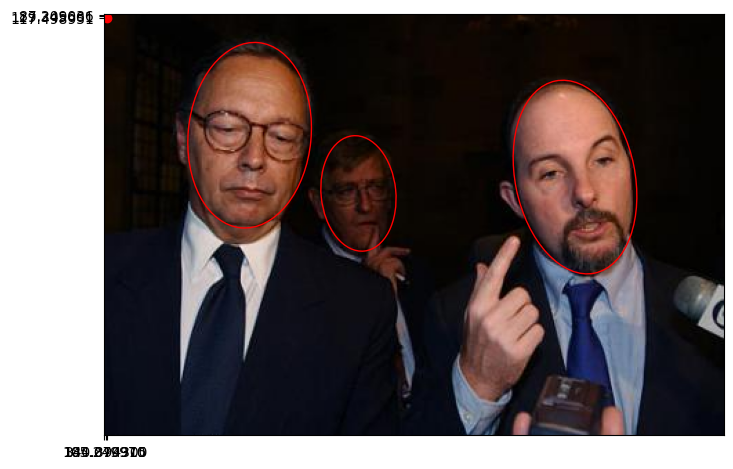

In [20]:
# let's retrieve the first image and its annotations from the dataframe
# let' also plot the coordinates of the faces on the image.
from matplotlib.patches import Ellipse

n = 1
img_path = annot_df.iloc[n, 0]
num_faces = annot_df.iloc[n, 1]
coords = annot_df.iloc[n, 2]
# coords consists of [major_axis_radius minor_axis_radius angle center_x center_y 1]

print('Image path: {}'.format(img_path))
print('Number of faces: {}'.format(num_faces))
print('Coordinates of faces: {}'.format(coords))

# let's read the image and plot it with ellipse annotations
img = io.imread(img_path)

def plot_image(img, coords):
    plt.figure()
    plt.imshow(img)
    for face in coords:
        plt.plot(face[3], face[4], 'ro')
        ellipse = Ellipse(xy=(float(face[3]), float(face[4])), width=float(face[1])*2, height=float(face[0])*2, angle=float(face[2])*180/np.pi + 90, edgecolor='r', fc='None')
        plt.gca().add_artist(ellipse)
    plt.show()

plot_image(img, coords)

In [21]:
from torchvision.transforms import Compose

class CustomCompose(Compose):
    def __call__(self, img):
        for t in self.transforms:
            img = t(img)
            if img is None:
                return None
        return img

In [22]:
#  Let’s create a dataset class for the FDDB dataset.

class FDDBDataset(Dataset):
    """FDDB dataset."""

    def __init__(self, df, root_dir, transform=None, for_training=True):
        """
        Arguments:
            df (dataframe): Dataframe with the annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.fddb_df = df
        self.root_dir = root_dir
        self.transform = transform
        self.for_training = for_training

    def __len__(self):
        return len(self.fddb_df)

    def __getitem__(self, idx):
        # print('getting')
        if torch.is_tensor(idx):
            idx = idx.tolist()

        while True:
            img_name = os.path.join(self.fddb_df.iloc[idx, 0])
            try: 
                image = io.imread(img_name)
            except Exception as e: 
                print('Error reading image {}'.format(img_name))
            num_faces = self.fddb_df.iloc[idx, 1]
            num_faces = int(num_faces)
            coords = self.fddb_df.iloc[idx, 2]
            coords = np.array(coords, dtype=np.float32)

            sample = {'image': image, 'num_faces': num_faces, 'coords': coords}

            if sample['image'].ndim != 3:
                # convert grayscale images to RGB
                sample['image'] = np.stack((sample['image'],)*3, axis=-1)

            if self.transform:
                sample = self.transform(sample)
                # print('Transform output',sample)
            if sample is not None:
                idx = (idx + 1) % len(self)
                return sample
            else:
                idx = (idx + 1) % len(self)
                # print('Trying image {}'.format(self.fddb_df.iloc[idx, 0]))
    
    # def __remove_image__(self, idx):
    #     print('Removing image {}'.format(self.fddb_df.iloc[idx, 0]))
    #     self.fddb_df.drop(idx, inplace=True)
    #     self.fddb_df.reset_index(drop=True, inplace=True)
    

class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        # print('rescaling')
        image, num_faces, coords = sample['image'], sample['num_faces'], sample['coords']

        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        img = transform.resize(image, (new_h, new_w))

        # update the coords of the faces
        if num_faces > 0:
            coords[:, 3] = coords[:, 3] * new_w / w
            coords[:, 4] = coords[:, 4] * new_h / h
            coords[:, 0] = coords[:, 0] * new_h / h
            coords[:, 1] = coords[:, 1] * new_w / w
        
        
        return {'image': img, 'num_faces': num_faces, 'coords': coords}


class RandomCrop(object):
    """Crop randomly the image in a sample.

    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size


    def __call__(self, sample):
        # print('cropping')
        image, num_faces, coords = sample['image'], sample['num_faces'], sample['coords']

        h, w = image.shape[:2]
        new_h, new_w = self.output_size

        top = np.random.randint(0, h - new_h + 1)
        left = np.random.randint(0, w - new_w + 1)

        image = image[top: top + new_h,
                      left: left + new_w]
        
        # update the coords of the faces
        if num_faces > 0:
            coords[:, 3] = coords[:, 3] - left
            coords[:, 4] = coords[:, 4] - top
        

            # check if the faces are still in the image.
            # if not, skip the image
            face_ratio = 1
            for face in coords:
                x, y, major_axis, minor_axis = face[3], face[4], face[0], face[1]
                # TODO: make this more accurate (consider the angle of the ellipse)
                if x - major_axis*face_ratio < 0 or x + major_axis*face_ratio > new_w or y - minor_axis*face_ratio < 0 or y + minor_axis*face_ratio > new_h:
                    return None

        return {'image': image, 'num_faces': num_faces, 'coords': coords}


class ToTensor(object):
    """Convert ndarrays in sample to Tensors.
        By default, coordinates are not converted to tensors. To convert them, set for_training to False.
    """

    def __init__(self, for_training=True):
        self.for_training = for_training

    def __call__(self, sample):
        # print('converting to tensor')
        image, num_faces, coords = sample['image'], sample['num_faces'], sample['coords']

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C x H x W
        image = image.transpose((2, 0, 1)) # (H, W, C) -> (C, H, W)

        if self.for_training:
            return {'image': torch.from_numpy(image).float(),
                    'num_faces': torch.tensor(num_faces),
                    }
        else:
            return {'image': torch.from_numpy(image),
                    'num_faces': torch.tensor(num_faces),
                    'coords': coords
                    }

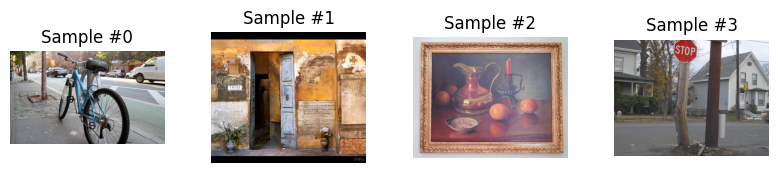

In [23]:
# Let’s instantiate class and iterate through the data samples.
face_dataset = FDDBDataset(df=complete_df, root_dir='data/FDDB/originalPics/')

fig = plt.figure()

for i, sample in enumerate(face_dataset):
    # print(i, 'Image shape:', sample['image'].shape, 'Number of faces:', sample['num_faces'], 'Coords:', sample['coords'])

    # plot image with coords (like the previous plot_image function)
    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    plt.imshow(sample['image'])
    if sample['num_faces'] > 0:
        for face in sample['coords']:
            plt.plot(face[3], face[4], 'ro')
            ellipse = Ellipse(xy=(float(face[3]), float(face[4])), width=float(face[1])*2, height=float(face[0])*2, angle=float(face[2])*180/np.pi + 90, edgecolor='r', fc='None')
            plt.gca().add_artist(ellipse)

    if i == 3:
        plt.show()
        break

In [11]:
# 000000043581.jpg
# 000000376442.jpg
# 000000231088.jpg
# 000000118209.jpg
# 000000376442.jpg

dir = 'data/coco/val2017/'

bad_images = [f'{dir}000000043581.jpg', f'{dir}000000376442.jpg', f'{dir}000000231088.jpg', f'{dir}000000118209.jpg', f'{dir}000000376442.jpg']

# remove bad images from the dataset
complete_df = complete_df[~complete_df['img_path'].isin(bad_images)]


In [25]:

# check the size of the images in the dataset
count = 0
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
for image in face_dataset:
    if image['image'].shape.__len__() != 3:
        print(image['image'].shape)
        count += 1
print(count)


Error reading image data/coco/val2017/000000231088.jpg


UnboundLocalError: cannot access local variable 'image' where it is not associated with a value

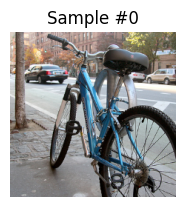

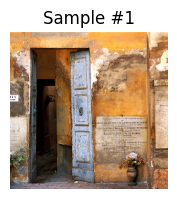

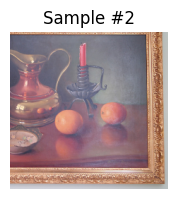

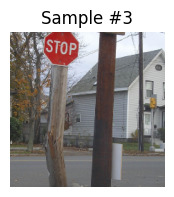

In [30]:
# Let’s instantiate this class with the transformations and iterate through the data samples.
face_dataset = FDDBDataset(df=complete_df,
                           root_dir='data/FDDB/originalPics/',
                            transform=CustomCompose([Rescale(256), RandomCrop(224), ToTensor(for_training=False)]))

fig = plt.figure()

# iterate through the dataset #(start at index 1000)
for i, sample in enumerate(face_dataset):
    # print(i, 'Image shape:', sample['image'].shape, 'Number of faces:', sample['num_faces'])
    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    plt.imshow(sample['image'].numpy().transpose((1, 2, 0)))
    
    if sample['num_faces'] > 0:
        for face in sample['coords']:
            plt.plot(face[3], face[4], 'ro')
            ellipse = Ellipse(xy=(float(face[3]), float(face[4])), width=float(face[1])*2, height=float(face[0])*2, angle=float(face[2])*180/np.pi + 90, edgecolor='r', fc='None')
            plt.gca().add_artist(ellipse)

    plt.show()

    if i == 3:
        plt.show()
        break


0 torch.Size([4, 3, 224, 224]) tensor([1, 1, 1, 1])
1 torch.Size([4, 3, 224, 224]) tensor([2, 1, 1, 1])
2 torch.Size([4, 3, 224, 224]) tensor([1, 1, 1, 1])
3 torch.Size([4, 3, 224, 224]) tensor([3, 1, 0, 1])


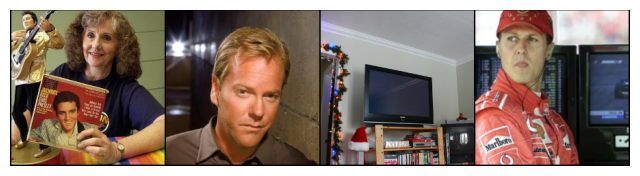

In [36]:
face_dataset = FDDBDataset(df= complete_df, root_dir='data/FDDB/originalPics/', transform=CustomCompose([
                                Rescale(256),
                                RandomCrop(224),
                                ToTensor()
                            ]))

# create a DataLoader
dataloader = DataLoader(face_dataset, batch_size=4,
                        shuffle=True, num_workers=0)


# Helper function to show a batch
def show_faces_batch(sample_batched):
    """Show image with faces for a batch of samples."""
    images_batch, num_faces_batch = \
            sample_batched['image'], sample_batched['num_faces']
    batch_size = len(images_batch)
    im_size = images_batch.size(2)

    grid = utils.make_grid(images_batch)
    plt.imshow(grid.numpy().transpose((1, 2, 0)))


for i_batch, sample_batched in enumerate(dataloader):

    print(i_batch, sample_batched['image'].size(), sample_batched['num_faces'])

    # observe 4th batch and stop.
    if i_batch == 3:
        plt.figure()
        show_faces_batch(sample_batched)
        plt.axis('off')
        plt.ioff()
        plt.show()
        break

In [116]:
# what is datasert size
print(len(face_dataset))



3226
